In [1]:
import torch
from torch import nn

import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(111)

In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [4]:
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import pandas as pd
import os


In [5]:
root_data_folder = "8bit_characters"
image_names = [root_data_folder + "/" + name for name in os.listdir(root_data_folder) if name.endswith(".jpg")]
print(image_names)

['8bit_characters/leonardo_5935302653_o.jpg', '8bit_characters/mysterio_5938497845_o.jpg', '8bit_characters/john-bender_5947476192_o.jpg', '8bit_characters/wheeljack_5982213732_o.jpg', '8bit_characters/spikor_5921532302_o.jpg', '8bit_characters/samus-aran-power-suit_6024447687_o.jpg', '8bit_characters/allison-reynolds_5947475934_o.jpg', '8bit_characters/calypso_5994982128_o.jpg', '8bit_characters/michaelangelo_5935302777_o.jpg', '8bit_characters/neytiri_5925081796_o.jpg', '8bit_characters/mortimer-shadow_5994422753_o.jpg', '8bit_characters/iceman_5938072442_o.jpg', '8bit_characters/lobot_5930961478_o.jpg', '8bit_characters/krista-sparks-grasshopper_5994422531_o.jpg', '8bit_characters/pee-wee-herman_5942000962_o.jpg', '8bit_characters/leeloo_5935305091_o.jpg', '8bit_characters/bamm-bamm_5991957878_o.jpg', '8bit_characters/arwen_5955334313_o.jpg', '8bit_characters/bride-of-frankenstien_5939327360_o.jpg', '8bit_characters/samwise-gamgee_5955895448_o.jpg', '8bit_characters/smitty_595463830

In [6]:
def get_df_rgb(img):
    image = img
    if isinstance(img, str):
        image = Image.open(img)
    
    n_dims = np.array(image).shape[-1]
    r, g, b = np.array(image).reshape(-1, n_dims).T
    # return pd.DataFrame({'r': r, 'g': g, 'b': b}).sample(n=sample_size)
    return pd.DataFrame({'r': r, 'g': g, 'b': b})

Custom data loader image: https://www.topbots.com/step-by-step-implementation-of-gans-part-2/

In [7]:
X_train = []
count = 0
for dir in image_names:
    try: 
        # pixel_size = 50
        img = Image.open(dir)
        img = img.convert("RGB")
        img = img.resize((32,32))
        img = np.asarray(img)/255
        X_train.append(img)
        count += 1
    except Exception as e:
        print(count)
        print(e)

In [8]:
X_train = np.asarray(X_train)

In [9]:
X_train.shape

(701, 32, 32, 3)

In [10]:
def plot_images(imgs, grid_size = 5):
    """
    imgs: vector containing all the numpy images
    grid_size: 2x2 or 5x5 grid containing images
    """
     
    fig = plt.figure(figsize = (8, 8))
    columns = rows = grid_size
    plt.title("Training Images")

    for i in range(1, columns*rows +1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        if i >= len(imgs):
            break
        plt.imshow(imgs[i])
    plt.show()

In [11]:
from numpy import savez_compressed

savez_compressed('8bit_characters_32x32.npz', X_train)

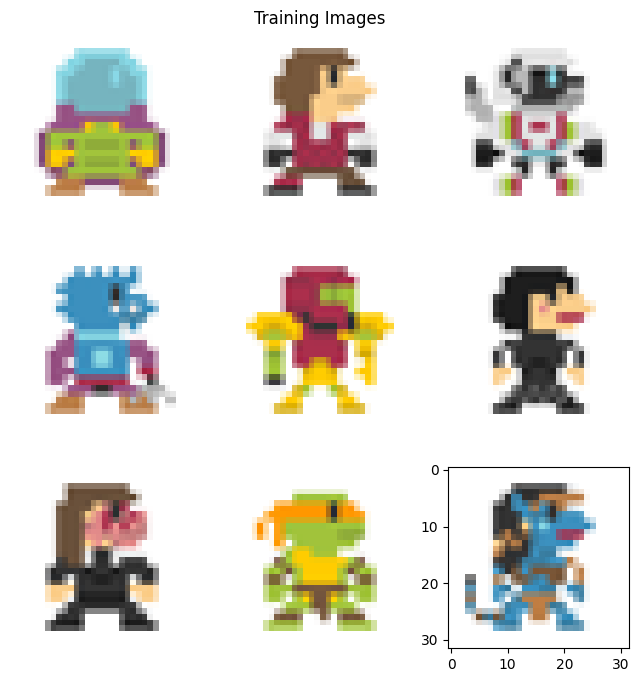

In [12]:
imgs = np.load('8bit_characters_32x32.npz')
 
# pls ignore the poor quality of the images as we are working with 32x32 sized images.
plot_images(imgs['arr_0'], 3)

In [13]:
from torch.utils.data import Dataset, DataLoader

class PixelCharacterDataset(Dataset):
    """Human Faces dataset."""
 
    def __init__(self, npz_imgs):
        """
        Args:
            npz_imgs (string): npz file with all the images (created in gan.ipynb)
        """
        self.imgs = npz_imgs
 
    def __len__(self):
        return len(self.imgs)
 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
 
        image = self.imgs[idx]
 
        return image

In [14]:
transpose_imgs = np.transpose(
    np.float32(imgs['arr_0']), (0, 3, 1, 2)
)
dset = PixelCharacterDataset(transpose_imgs)

dataloader = DataLoader(dset, batch_size=32, shuffle=True)

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # input to generator is something like (batch_size, 100, 1, 1)
        # this means that we are passing a batch of 32 100 random numbers to the generator
        self.model = nn.Sequential(
          nn.ConvTranspose2d(in_channels = 100, out_channels = 512 , kernel_size = 4, stride = 1, padding = 0, bias = False),
          # the output from the above will be b_size ,512, 4,4
          nn.BatchNorm2d(num_features = 512), # From an input of size (b_size, C, H, W), pick num_features = C
          nn.ReLU(inplace = True),
 
          nn.ConvTranspose2d(in_channels = 512, out_channels = 256 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,256, 8,8
          nn.BatchNorm2d(num_features = 256),
          nn.ReLU(inplace = True),
 
          nn.ConvTranspose2d(in_channels = 256, out_channels = 128 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,128, 16,16
          nn.BatchNorm2d(num_features = 128),
          nn.ReLU(inplace = True),
 
          nn.ConvTranspose2d(in_channels = 128, out_channels = 3 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,3, 32,32
          nn.Tanh()
         
        )
 
    def forward(self, x):
        return self.model(x)


In [16]:
class Discriminator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = nn.Sequential(
 
            # input is (3, 32, 32)
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32, 16, 16
            nn.LeakyReLU(0.2, inplace=True),
 
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32*2, 8, 8
            nn.BatchNorm2d(32 * 2),
            nn.LeakyReLU(0.2, inplace=True),
 
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32*4, 4, 4
            nn.BatchNorm2d(32 * 4),
            nn.LeakyReLU(0.2, inplace=True),
 
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 256, 2, 2
            # NOTE: spatial size of this layer is 2x2, hence in the final layer, the kernel size must be 2 instead (or smaller than) 4
            nn.BatchNorm2d(32 * 8),
            nn.LeakyReLU(0.2, inplace=True),
 
            nn.Conv2d(in_channels = 256, out_channels = 1, kernel_size = 2, stride = 2, padding = 0, bias=False),
            # ouput from above layer is b_size, 1, 1, 1
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)
    




In [17]:
print(device)

cuda:0


In [18]:
ex_dis = Generator().to(device=device)

randn = torch.randn((32, 100, 1, 1), device=device)
# ex_dis(randn)
ex_dis(randn)


: 

: 

In [28]:
def init_weights(m):
    if type(m) == nn.ConvTranspose2d:
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)


In [29]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(init_weights)
discriminator.apply(init_weights)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (12): Sigmoid()
  )
)

In [30]:
lr = 0.001 # learning rate
num_epochs = 100 # number of epochs
def backward_hook(grad):
    print(grad)
loss_function = nn.BCELoss() # Binary Cross Entropy Loss (since we are doing binary classification - whether the data is real or fake)


In [31]:
# We will use Adam optimizer
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

In [33]:
output = generator(torch.randn((32, 100, 1, 1)).to(device))
print(output.type())

img_plot = np.transpose(output.detach().cpu(), (0,2,3,1)) # .detach().cpu() is imp for copying fake_img tensor to host memory first
img_plot = (img_plot + 1)/2
plot_images(np.array(img_plot).astype(np.float32))



: 

: 

In [ ]:
# going over the entire dataset 10 times
num_epochs = 1000
for e in range(num_epochs):
     
    # pick each batch b of input images: shape of each batch is (32, 3, 32, 32)
    for i, b in enumerate(dataloader):
 
        ##########################
        ## Update Discriminator ##
        ##########################
 
        # Loss on real images
         
        # clear the gradient
        optimizer_discriminator.zero_grad() # set the gradients to 0 at start of each loop because gradients are accumulated on subsequent backward passes
        # compute the D model output
        yhat = discriminator(b.to(device)).view(-1) # view(-1) reshapes a 4-d tensor of shape (2,1,1,1) to 1-d tensor with 2 values only
        # specify target labels or true labels
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_real = loss_function(yhat, target)
        # calculate gradients -  or rather accumulation of gradients on loss tensor
        loss_real.backward()
 
        # Loss on fake images
 
        # generate batch of fake images using G
        # Step1: creating noise to be fed as input to G
        noise = torch.randn(len(b), 100, 1, 1, device = device)
        # Step 2: feed noise to G to create a fake img (this will be reused when updating G)
        fake_img = generator(noise) 
 
        # compute D model output on fake images
        yhat = discriminator.cuda()(fake_img.detach()).view(-1) # .cuda() is essential because our input i.e. fake_img is on gpu but model isnt (runtimeError thrown); detach is imp: Basically, only track steps on your generator optimizer when training the generator, NOT the discriminator. 
        # specify target labels
        target = torch.zeros(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_fake = loss_function(yhat, target)
        # calculate gradients
        loss_fake.backward()
 
        # total error on D
        loss_disc = loss_real + loss_fake
 
        # Update weights of D
        optimizer_discriminator.step()
 
        ##########################
        #### Update Generator ####
        ##########################
 
        # clear gradient
        optimizer_generator.zero_grad()
        # pass fake image through D
        yhat = discriminator.cuda()(fake_img).view(-1)
        # specify target variables - remember G wants D *to think* these are real images so label is 1
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_gen = loss_function(yhat, target)
        # calculate gradients
        loss_gen.backward()
        # update weights on G
        optimizer_generator.step()
 
 
        ####################################
        #### Plot some Generator images ####
        ####################################
 
        # during every epoch, print images at every 10th iteration.
        if i% 10 == 0:
            # convert the fake images from (b_size, 3, 32, 32) to (b_size, 32, 32, 3) for plotting 
            img_plot = np.transpose(fake_img.detach().cpu(), (0,2,3,1)) # .detach().cpu() is imp for copying fake_img tensor to host memory first
            img_plot = (img_plot + 1)/2
            plot_images(img_plot)
            print("********************")
            print(" Epoch %d and iteration %d " % (e, i))